<a href="https://colab.research.google.com/github/jiayuankeliang/309CourseWork2/blob/main/model_implementation_and_reslut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rustin96","key":"0f80a220c3c09d55b32c93025d2c2d3b"}'}

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600  ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

100% 609M/612M [00:04<00:00, 126MB/s]
100% 612M/612M [00:04<00:00, 149MB/s]


In [7]:
import zipfile

filename = '/content/gtsrb-german-traffic-sign.zip'

with zipfile.ZipFile(filename, 'r') as zip_ref:
  zip_ref.extractall('.')

In [8]:
import numpy as np
import os
from PIL import Image
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [9]:
img_height = 32
img_width = 32

In [10]:
data = []
labels = []
classes = 43

with tf.device('/GPU:0'):
  for i in range(classes):
      path = os.path.join('/content/Train',str(i))
      images = os.listdir(path)

      for image in images:
        image = Image.open(os.path.join(path, image))
        image = image.resize((img_height,img_width))
        image = np.array(image)
        data.append(image)
        labels.append(i)

data = np.array(data)
labels = np.array(labels)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)

In [12]:
X_train.shape, y_train.shape

((31367, 32, 32, 3), (31367,))

In [13]:
X_val.shape, y_val.shape

((7842, 32, 32, 3), (7842,))

In [14]:
X_train = X_train/255
X_val = X_val/255

In [15]:
plt.figure(figsize=(100, 100))
for i in range(100):
  ax = plt.subplot(10, 10, i + 1)
  plt.imshow(X_train[i])
  plt.title(y_train[i])
  plt.axis("off")

In [37]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),

    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    
    tf.keras.layers.Dense(43, activation='softmax')
])

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 256)       295168    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 256)        0         
 2D)                                                    

In [76]:
model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

In [77]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_loss',
    save_best_only=True
)

In [78]:
with tf.device('/GPU:0'):
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks=[checkpoint_callback])

Epoch 1/20
981/981 [==============================] - 11s 8ms/step - loss: 1.2312 - accuracy: 0.6411 - val_loss: 0.0851 - val_accuracy: 0.9760
Epoch 2/20
981/981 [==============================] - 7s 8ms/step - loss: 0.1329 - accuracy: 0.9613 - val_loss: 0.0280 - val_accuracy: 0.9925
Epoch 3/20
981/981 [==============================] - 8s 8ms/step - loss: 0.0730 - accuracy: 0.9793 - val_loss: 0.0245 - val_accuracy: 0.9939
Epoch 4/20
981/981 [==============================] - 7s 7ms/step - loss: 0.0574 - accuracy: 0.9837 - val_loss: 0.0154 - val_accuracy: 0.9962
Epoch 5/20
981/981 [==============================] - 7s 8ms/step - loss: 0.0448 - accuracy: 0.9874 - val_loss: 0.0188 - val_accuracy: 0.9962
Epoch 6/20
981/981 [==============================] - 10s 10ms/step - loss: 0.0390 - accuracy: 0.9894 - val_loss: 0.0204 - val_accuracy: 0.9950
Epoch 7/20
981/981 [==============================] - 8s 9ms/step - loss: 0.0402 - accuracy: 0.9888 - val_loss: 0.0139 - val_accuracy: 0.9968
Epo

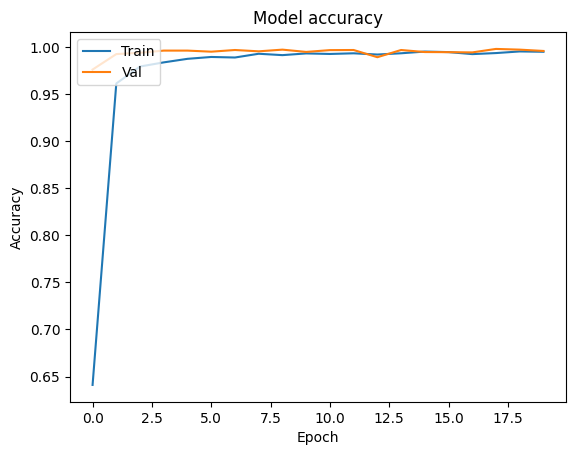

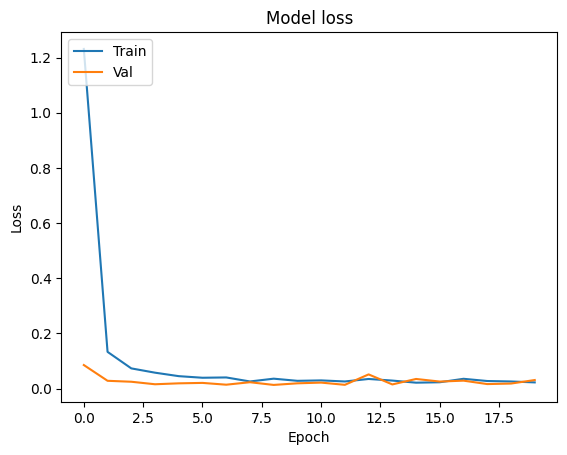

In [79]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [47]:
test = pd.read_csv('/content/Test.csv')

y_test = test["ClassId"].values
imgs = test["Path"].values

data=[]

with tf.device('/GPU:0'):
    for img in imgs:
        image = Image.open('/content/'+img)
        image = image.resize([img_height, img_width])
        data.append(np.array(image))

X_test=np.array(data)

In [48]:
model = tf.keras.models.load_model('best_model.h5')

In [49]:
X_test = X_test/255
model_predict = model.predict(X_test)

correct_predict = []
incorrect_predict = []

for i in range(len(model_predict)):
  label = np.argmax(model_predict[i])
  if label == y_test[i]:
    correct_predict.append(i)
  else:
    incorrect_predict.append(i)

accuracay = len(correct_predict) / (len(correct_predict) + len(incorrect_predict))
print('accuracay: {}'.format(accuracay))

395/395 [==============================] - 39s 99ms/step
accuracay: 0.9818685669041963


In [50]:
layer_outputs = [layer.output for layer in model.layers[0:6]]

In [51]:
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)

1/1 [==============================] - 0s 33ms/step


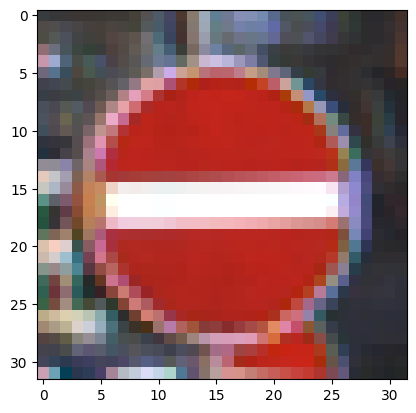

In [63]:
img = X_test[1000]
plt.imshow(img)
img = img.reshape(1, 32, 32, 3)
activations = activation_model.predict(img)

In [64]:
activations[0].shape

(1, 30, 30, 32)

<function matplotlib.pyplot.show(close=None, block=None)>

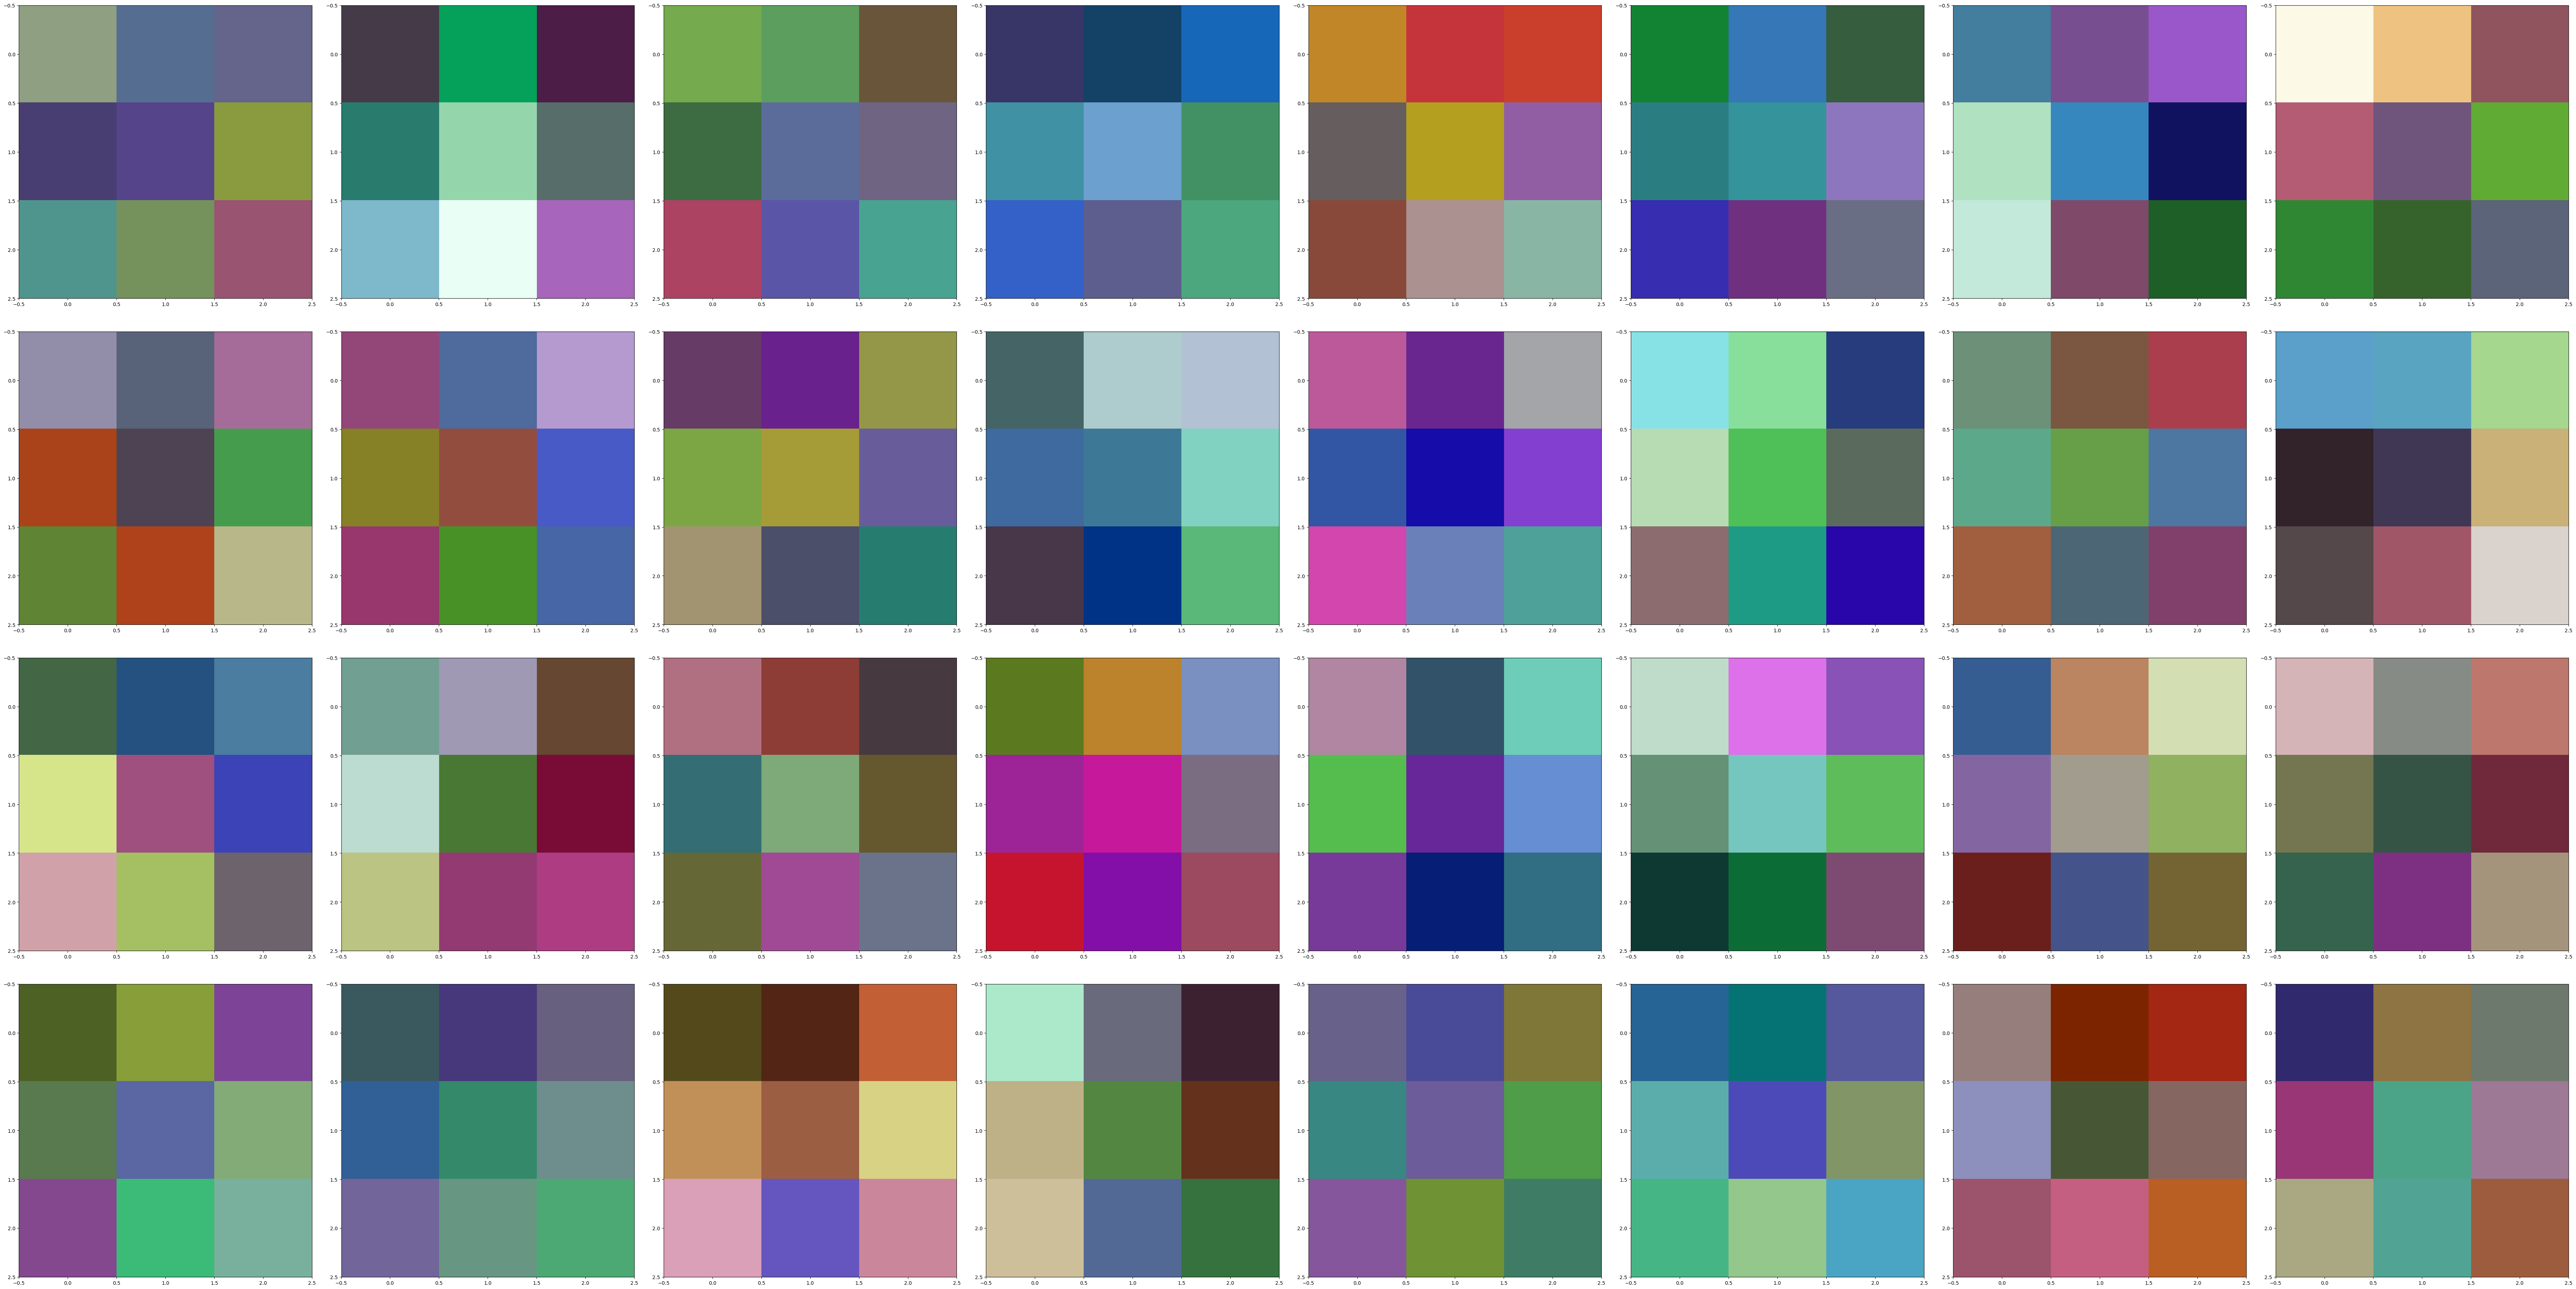

In [65]:
conv_layer = model.get_layer('conv2d_16')

#get kernel weights
kernel_weights = conv_layer.get_weights()[0]

# normalize weights
kernel_weights_norm = (kernel_weights - np.min(kernel_weights)) / (np.max(kernel_weights) - np.min(kernel_weights))

fig, ax = plt.subplots(nrows=4, ncols=8, figsize=(80, 40))
for i in range(4):
  for j in range(8):
    ax[i, j].imshow(kernel_weights_norm[:,:,:,i*8 + j])
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.1, hspace=0.1)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

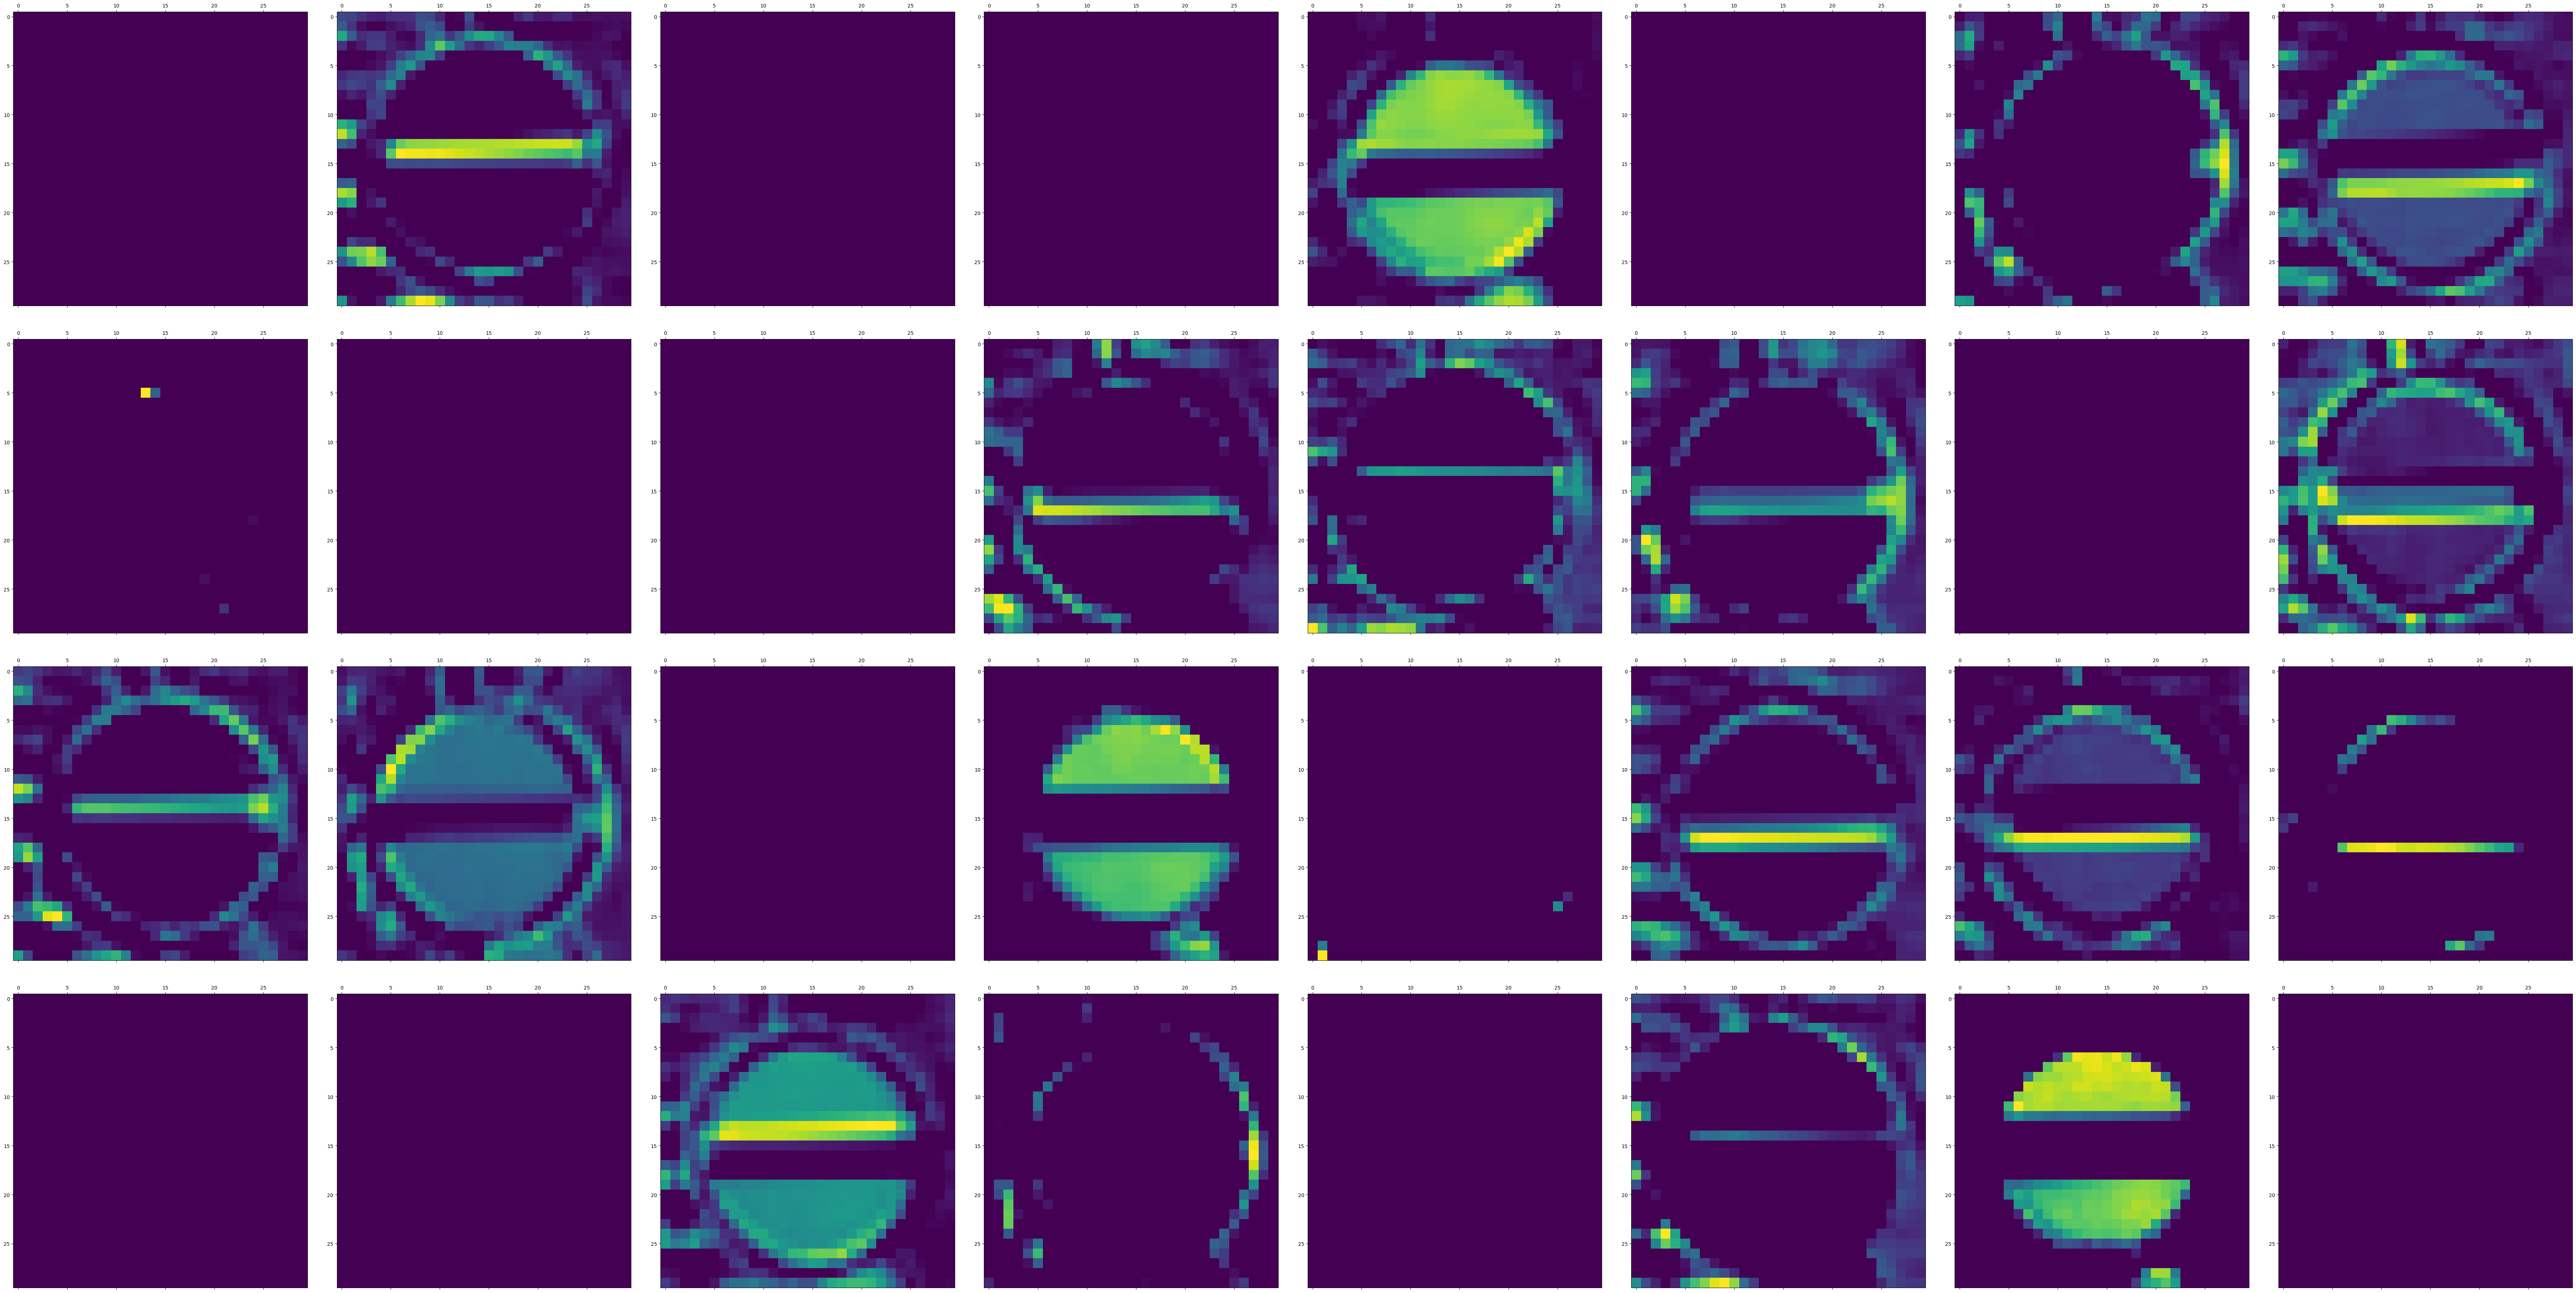

In [66]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=4, ncols=8, figsize=(80, 40))
for i in range(4):
  for j in range(8):
    ax[i, j].matshow(activations[0][0, :, :, i * 8 + j])
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.1, hspace=0.1)
plt.show

In [57]:
fig, ax = plt.subplots(nrows=8, ncols=8, figsize=(80, 80))
for i in range(8):
  for j in range(8):
    ax[i, j].matshow(activations[1][0, :, :, i * 8 + j], cmap='viridis')
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.1, hspace=0.1)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

In [58]:
fig, ax = plt.subplots(nrows=8, ncols=8, figsize=(80, 80))
for i in range(8):
  for j in range(8):
    ax[i, j].matshow(activations[2][0, :, :, i * 8 + j], cmap='viridis')
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.1, hspace=0.1)
plt.grid(False)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

In [61]:
fig, ax = plt.subplots(nrows=16, ncols=8, figsize=(80, 160))
for i in range(16):
  for j in range(8):
    ax[i, j].matshow(activations[3][0, :, :, i * 8 + j], cmap='viridis')
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.1, hspace=0.1)
plt.grid(False)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

In [62]:
fig, ax = plt.subplots(nrows=32, ncols=8, figsize=(80, 320))
for i in range(32):
  for j in range(8):
    ax[i, j].matshow(activations[4][0, :, :, i * 8 + j], cmap='viridis')
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.1, hspace=0.1)
plt.grid(False)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>